In [1]:
import os
from ictdeploy import Simulator as Sim

In [2]:
import json
import pandas as pd

In [3]:
data_power_grid_folder = "PowerGridData"
loads = pd.DataFrame(json.load(open(os.path.join(data_power_grid_folder, 'load.json'))))
loads.index = map(int, loads.index)
loads.head()

,bus,const_i_percent,const_z_percent,in_service,name,p_kw,q_kvar,scaling,sn_kva,type
0,2,0.0,0.0,True,LoadR1,10.0,1.0,1.0,None,None
1,12,0.0,0.0,True,LoadR11,10.0,1.0,1.0,None,None
10,37,0.0,0.0,True,LoadC14,10.0,1.0,1.0,None,None
11,40,0.0,0.0,True,LoadC17,10.0,1.0,1.0,None,None
12,41,0.0,0.0,True,LoadC18,10.0,1.0,1.0,None,None


In [4]:
#create empty simulator
sim = Sim()

In [5]:
#create Meta-model

set_attrs = [n+"_p_kw" for n in loads.name]
set_attrs += [n+"_q_kvar" for n in loads.name]

sim.edit.add_meta(
        name="PowerGridMeta",
        set_attrs=set_attrs,
        # get_attrs=["Feeder_p_kw", "Feeder_q_kvar"]
        get_attrs=[]
    )

'PowerGridMeta'

In [6]:
print(len(set_attrs))

30


In [7]:
#create Model
sim.edit.add_model(
        name="PowerGridModel",
        meta="PowerGridMeta",
        image="integrcity/ict-pandapower",
        wrapper=os.path.join("wrappers", "power_grid_wrap.py"),
        command=None,
        files=[os.path.join(data_power_grid_folder, f) for f in os.listdir(data_power_grid_folder)]
    )

'PowerGridModel'

In [8]:
#add node
sim.edit.add_node(
        name="PowerGrid",
        model="PowerGridModel",
        init_values={},
        is_first=False
    )

'PowerGrid'

In [9]:
#create Meta-model

sim.edit.add_meta(
        name="ConsumerMeta",
        set_attrs=[],
        get_attrs=["p_kw", "q_kvar"]
    )

'ConsumerMeta'

In [10]:
#create Model
sim.edit.add_model(
        name="ConsumerModel",
        meta="ConsumerMeta",
        image="integrcity/ict-simple",
        wrapper=os.path.join("wrappers", "consumer_wrap.py"),
        command=None,
        files=[]
    )

'ConsumerModel'

In [11]:
#add node
for n in loads.name:
    sim.edit.add_node(
        name=n,
        model="ConsumerModel",
        init_values={"loc": 5.0, "scale": 0.5},
        is_first=True
    )

In [12]:
sim.edit.nodes

,meta,model,to_set,to_get,image,wrapper,files,command,init_values,is_first
LoadC1,ConsumerMeta,ConsumerModel,[],"[p_kw, q_kvar]",integrcity/ict-simple,wrappers/consumer_wrap.py,[],None,"{'loc': 5.0, 'scale': 0.5}",True
LoadC12,ConsumerMeta,ConsumerModel,[],"[p_kw, q_kvar]",integrcity/ict-simple,wrappers/consumer_wrap.py,[],None,"{'loc': 5.0, 'scale': 0.5}",True
LoadC13,ConsumerMeta,ConsumerModel,[],"[p_kw, q_kvar]",integrcity/ict-simple,wrappers/consumer_wrap.py,[],None,"{'loc': 5.0, 'scale': 0.5}",True
LoadC14,ConsumerMeta,ConsumerModel,[],"[p_kw, q_kvar]",integrcity/ict-simple,wrappers/consumer_wrap.py,[],None,"{'loc': 5.0, 'scale': 0.5}",True
LoadC17,ConsumerMeta,ConsumerModel,[],"[p_kw, q_kvar]",integrcity/ict-simple,wrappers/consumer_wrap.py,[],None,"{'loc': 5.0, 'scale': 0.5}",True
LoadC18,ConsumerMeta,ConsumerModel,[],"[p_kw, q_kvar]",integrcity/ict-simple,wrappers/consumer_wrap.py,[],None,"{'loc': 5.0, 'scale': 0.5}",True
LoadC19,ConsumerMeta,ConsumerModel,[],"[p_kw, q_kvar]",integrcity/ict-simple,wrappers/consumer_wrap.py,[],None,"{'loc': 5.0, 'scale': 0.5}",True
LoadC20,ConsumerMeta,ConsumerModel,[],"[p_kw, q_kvar]",integrcity/ict-simple,wrappers/consumer_wrap.py,[],None,"{'loc': 5.0, 'scale': 0.5}",True
LoadI2,ConsumerMeta,ConsumerModel,[],"[p_kw, q_kvar]",integrcity/ict-simple,wrappers/consumer_wrap.py,[],None,"{'loc': 5.0, 'scale': 0.5}",True
LoadR1,ConsumerMeta,ConsumerModel,[],"[p_kw, q_kvar]",integrcity/ict-simple,wrappers/consumer_wrap.py,[],None,"{'loc': 5.0, 'scale': 0.5}",True


In [13]:
for n in loads.name:
    sim.edit.add_multiple_links_between_two_nodes(
        get_node=n, 
        set_node="PowerGrid", 
        get_attrs=["p_kw", "q_kvar"],
        set_attrs=["{}_p_kw".format(n), "{}_q_kvar".format(n)],
        units=["p_kw", "q_kvar"]
    )

In [14]:
print(len(sim.edit.links))
sim.edit.links

30


,get_attr,get_node,set_attr,set_node
0,p_kw,LoadR1,LoadR1_p_kw,PowerGrid
1,q_kvar,LoadR1,LoadR1_q_kvar,PowerGrid
2,p_kw,LoadR11,LoadR11_p_kw,PowerGrid
3,q_kvar,LoadR11,LoadR11_q_kvar,PowerGrid
4,p_kw,LoadC14,LoadC14_p_kw,PowerGrid
5,q_kvar,LoadC14,LoadC14_q_kvar,PowerGrid
6,p_kw,LoadC17,LoadC17_p_kw,PowerGrid
7,q_kvar,LoadC17,LoadC17_q_kvar,PowerGrid
8,p_kw,LoadC18,LoadC18_p_kw,PowerGrid
9,q_kvar,LoadC18,LoadC18_q_kvar,PowerGrid


In [15]:
import networkx as nx
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


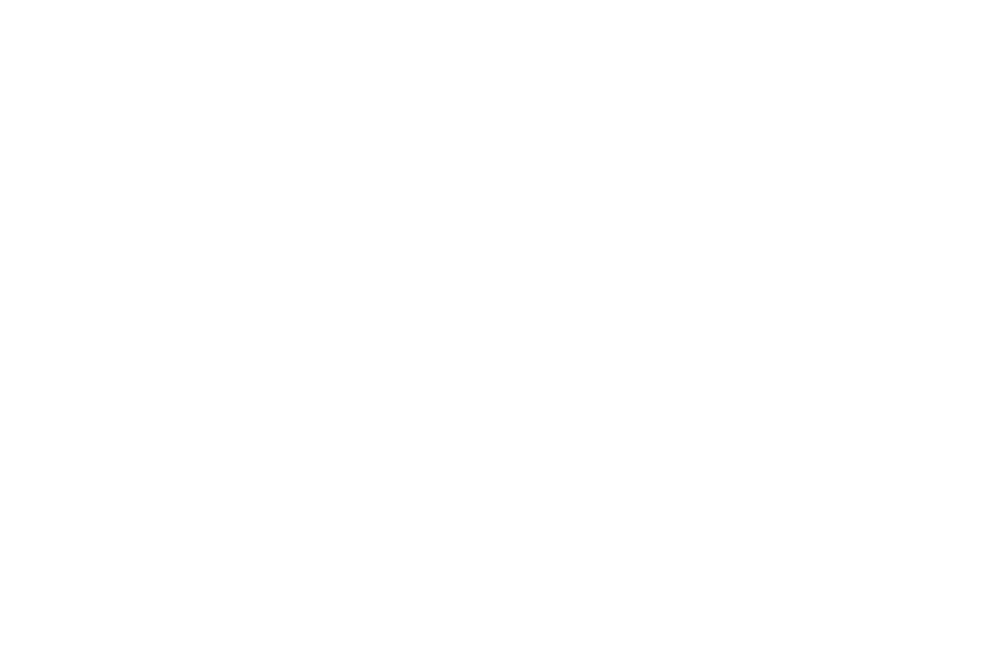

In [16]:
%matplotlib notebook
plt.figure(figsize=(9, 6))
g = sim.edit.graph
nx.draw(g, with_labels=True, font_weight='bold')

In [17]:
grp0 = sim.create_group(*[n for n in loads.name])
grp1 = sim.create_group("PowerGrid")

In [18]:
sim.create_sequence(grp0, grp1)
sim.create_steps([60] * 5)

In [19]:
logs = sim.run_simulation(server="server.py")
print(logs.keys())

dict_keys(['aux', 'orc', 'nodes'])


In [20]:
for l in sim.get_logs(logs["orc"]):
    if "INFO" in l:
        print(l)

INFO - 2018-04-12 07:16:04,532 - Connected to 172.17.01/obnl_vhost
INFO - 2018-04-12 07:16:04,551 - scheduler initialised.
INFO - 2018-04-12 07:16:04,992 - Simulator LoadC1 is connected.
INFO - 2018-04-12 07:16:05,231 - Simulator LoadC12 is connected.
INFO - 2018-04-12 07:16:05,625 - Simulator LoadC13 is connected.
INFO - 2018-04-12 07:16:06,059 - Simulator LoadC14 is connected.
INFO - 2018-04-12 07:16:06,497 - Simulator LoadC17 is connected.
INFO - 2018-04-12 07:16:06,964 - Simulator LoadC18 is connected.
INFO - 2018-04-12 07:16:07,419 - Simulator LoadC19 is connected.
INFO - 2018-04-12 07:16:07,947 - Simulator LoadC20 is connected.
INFO - 2018-04-12 07:16:08,264 - Simulator LoadI2 is connected.
INFO - 2018-04-12 07:16:08,644 - Simulator LoadR1 is connected.
INFO - 2018-04-12 07:16:09,106 - Simulator LoadR11 is connected.
INFO - 2018-04-12 07:16:09,580 - Simulator LoadR15 is connected.
INFO - 2018-04-12 07:16:09,956 - Simulator LoadR16 is connected.
INFO - 2018-04-12 07:16:10,376 - Si

In [21]:
sim.results.connect_to_results_db()
res = sim.results.list_of_available_results
res.loc[res["IN/OUT"] == "X"]

,IN/OUT,Node,Attribute
24,X,PowerGrid,Feeder_p_kw
42,X,PowerGrid,Feeder_q_kvar


In [22]:
results = sim.results.get_results_by_pattern("X*PowerGrid*")
results.keys()

dict_keys(['X||PowerGrid||Feeder_p_kw', 'X||PowerGrid||Feeder_q_kvar'])

<IPython.core.display.Javascript object>


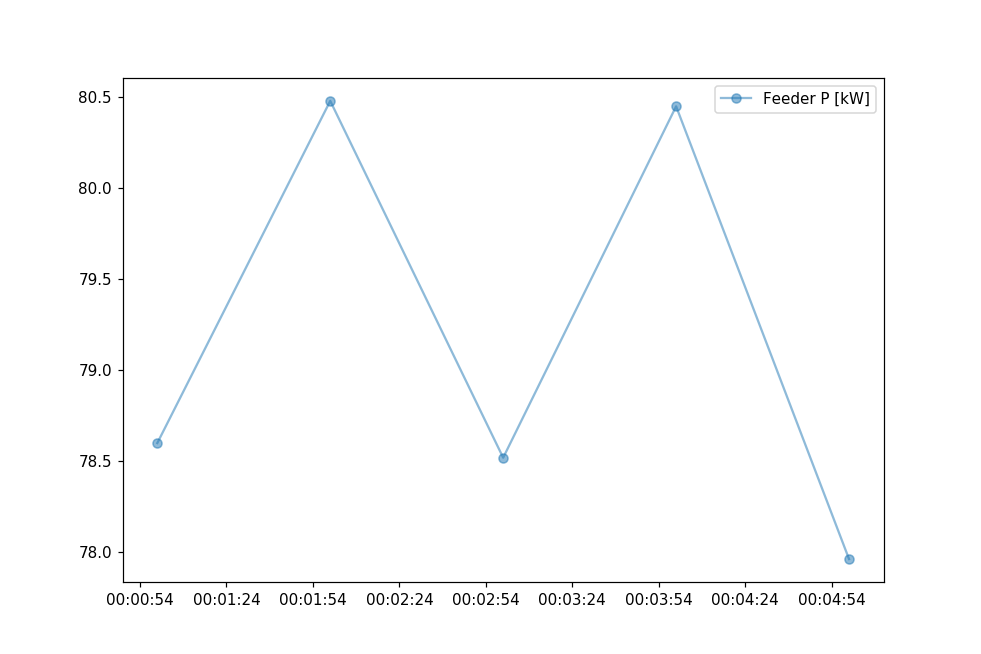

In [23]:
%matplotlib notebook

plt.figure(figsize=(9, 6))
plt.plot(-1*results['X||PowerGrid||Feeder_p_kw'], "-o", label="Feeder P [kW]", alpha=0.5)
plt.legend()